**Investigating the Relationship Between Birth Month and Business Success**

By Alex Freedman

Malcolm Gladwell in his famous book, Outliers, postulated that, for youth hockey players in Canada, being born earlier in a given year provided an enormous step up compared to those youths born later in the year.  In order to make teaching children efficient, children must be grouped into arbitrary sets so as to create a limit on the number of children per set.  Typically, children are grouped into grades with a cutoff point of January 1st. These grades are then used to determine extracurricular groupings including sporting teams, summer camps, etc. This leads to those children born in earlier months of a given year with distinct mental and physical growth advantages as well as significantly larger experiential banks over their peers born in later months.  Gladwell found evidence that these advantages lead to higher rates of success in youth hockey for those youths born earlier in a year than their younger counterparts born in the middle and end of that same year.  

I am setting out to continue developing Mr. Gladwell’s theory, by determining whether earlier birth months in a year for an individual can indicate future success in business.  Unlike youth hockey, where much of early success can be due to sheer physical advantages that an older child may have over a slightly younger one, success in business should not be determined by physical growth advantages.  Additionally, for the purposes of this analysis, where “success in business” will be defined by a dataset of prominent fortune 500 CEO’s, success has occurred far into adulthood, when any developmental head start would not be as critical of a factor. Essentially, the question is, do developmental head starts, relative to your arbitrarily established peer group, snowball into a lifetime of relative advantage, and therefore a predisposition for success in business?  


In [2]:
import numpy as np #importing numpy
import pandas as pd #importing pandas
from bs4 import BeautifulSoup #importing Beautiful Soup
import requests
import html5lib #importing html5lib, as per Pandas read_html request
import re


The following data was gathered from http://www.statisticbrain.com/birth-month-statistics/ and averages out each month's number of births in the United States over the last 30 years. The csv was copied and was imported as a pandas dataframe. Later, we will discuss the results graphically.

In [3]:
path_to_bday_frequencies = '/Users/alexfreedman/Desktop/Stern/Data_Bootcamp/bday_frequencies 2.csv'
bday_densities = pd.read_csv(path_to_bday_frequencies)
bday_densities.sort_values('month_num')

,month,month_num,freq,density
9,January,1,319297,0.079654
11,February,2,299235,0.074649
5,March,3,335786,0.083767
10,April,4,308809,0.077037
7,May,5,334437,0.083431
4,June,6,336251,0.083883
2,July,7,347934,0.086798
0,August,8,362798,0.090506
1,September,9,350711,0.087491
3,October,10,347354,0.086653


Using the help of my data scientist friend I was able to scrape a wikipedia table of prominent CEO's who will serve as my dataset for this project. The process underwent is as follows:

1. Use the `requests.get` function to pull the html of the relevant Wikipedia Table
2. Turn this into a `BeautifulSoup` object.
3. Using Chrome's `inspect source` feature, we can determine that we want the `table` html tag corresponding to the attribute `class=wikitable sortable`.
4. Use `pandas`'s handy `read_html` function to convert the html table into a DataFrame.
5. Fix the first row as the column headers, and remove that row. Reindex the df from the new first row.

In [4]:
ceo = requests.get("http://en.wikipedia.org/wiki/List_of_chief_executive_officers") #use the
# requests package 'get' function to pull the html of the wikipedia page of CEO's

ceo_soup = BeautifulSoup(ceo.content)
ceo_table = ceo_soup.find('table', attrs={'class':'wikitable sortable'})
#wikitable sortable is the beginning of the table in the html (viewed with view source of chrome)
dfceo = pd.read_html(str(ceo_table),skiprows=0,encoding="utf-8")[0]
#the pandas read_html function reads the ceo_table html and turns it into a dataframe
dfceo.columns = dfceo.iloc[0] #make the first row the columns of the df
dfceo = dfceo.reindex(dfceo.index.drop(0)) #reindex the df to start at line 1


/Users/alexfreedman/anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


The next three functions will do the heavy lifting associated with:
- Finding the http link associated with each CEO row in the table
- Cleaning the links to remove unwanted footnotes with a `regex`. (Otherwise an error will be thrown.)
- Finding the birthday - if it is available - from the Wikipedia page corresponding to the standardized link. 

> - Each function uses a list comprehension to return an array. They will be used in a pandas `assign` call below to append the scraped data to the CEO dataframe created above.

> - The original `BeautifulSoup` call is reused for these purposes.

[1]:http://treyhunner.com/2015/12/python-list-comprehensions-now-in-color/

In [5]:
def find_link(s, prestr = 'https://wikipedia.org'): #grab each wiki link from wiki table rows
    return [prestr + ceo_soup.find('a', text=elem)['href'] for elem in s]

def remove_footnote(s): #use regex to remove footnotes (from links, but can be used elsewhere)
    return [re.sub('\[.*?\]','',elem) for elem in s]

def find_birthday(wl): #span with class=bday 
    #relevancy is determined from Chrome's View Source
    bdays = [BeautifulSoup(requests.get(elem).content)
             .find('span', attrs={'class':'bday'}) for elem in wl]
    
    bday_stage = ["" if elem is None else elem.text for elem in bdays]
    bday_format = pd.to_datetime(bday_stage, format='%Y-%m-%d', errors='coerce') #format
    #the string birthday's into pandas datetime objects. errors='coerce' is required
    #to not throw errors when trying to read empty ("") birthdays, and instead convert to NaN
    return bday_format

Using the functions defined above, create new (final) df called `dfceo_final`. `find_birthday()` converts the string birthday elements into pandas datetime objects in `birth_date`. Once they are formatted as such, creating `birth_year`, `birth_quarter`, `birth_month`, and `birth_day` variables are straightforward. 

In [6]:
dfceo_final = (dfceo.assign(wiki_link = lambda x: find_link(s=remove_footnote(x.Executive)))
               .assign(birth_date = lambda x: find_birthday(x.wiki_link))
               .assign(birth_year = lambda x: x.birth_date.dt.year,
                      birth_quarter = lambda x: x.birth_date.dt.quarter,
                      birth_month = lambda x: x.birth_date.dt.month,
                      birth_day = lambda x: x.birth_date.dt.day))

/Users/alexfreedman/anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [7]:
dfceo_final

,Company,Executive,Title,Since,Education,Notes,Updated,wiki_link,birth_date,birth_day,birth_month,birth_quarter,birth_year
1,Accenture,Pierre Nanterme,Chairman and CEO[1],2011,ESSEC,"Replaced William D. Green, who became executiv...",2015-01-17,https://wikipedia.org/wiki/Pierre_Nanterme,NaT,NaN,NaN,NaN,NaN
2,ACE Limited,Evan G. Greenberg,"Chairman, President, and CEO[2]",2004,New York University (attended); College of Ins...,Former COO of American International Group.,2015-01-17,https://wikipedia.org/wiki/Evan_G._Greenberg,NaT,NaN,NaN,NaN,NaN
3,Aditya Birla Group,Kumar Birla,Chairman[3],1995[3],NaN,Part of the Birla family business house in India.,2015-01-17,https://wikipedia.org/wiki/Kumar_Birla,1967-06-14,14,6,2,1967
4,Adobe Systems,Shantanu Narayen,President and CEO[4],2007,"Osmania University, Bowling Green State Univer...",Formerly with Apple Inc.,2015-01-17,https://wikipedia.org/wiki/Shantanu_Narayen,1963-05-27,27,5,2,1963
5,Agenus,Garo H. Armen,"Founder, Chairman, CEO[5]",1994,City University of New York,NaN,2015-01-17,https://wikipedia.org/wiki/Garo_H._Armen,1953-01-31,31,1,1,1953
6,Alliance Boots,Stefano Pessina,Executive Vice Chairman and acting CEO[6],2006,Polytechnic University of Milan,NaN,2015-01-17,https://wikipedia.org/wiki/Stefano_Pessina,NaT,NaN,NaN,NaN,NaN
7,Alcatel-Lucent,Michel Combes,CEO[7],2013,École Polytechnique,Previously CEO of Vodafone,2015-01-17,https://wikipedia.org/wiki/Michel_Combes,1962-03-29,29,3,1,1962
8,Alcoa,Klaus Kleinfeld,Chairman and CEO[8],2008,"Georg August University, University of Würzburg",Formerly with Siemens AG,2015-01-17,https://wikipedia.org/wiki/Klaus_Kleinfeld,1957-11-06,6,11,4,1957
9,Amazon.com,Jeff Bezos,"Founder, President, CEO, and Chairman[9]",1994,Princeton University,NaN,2015-01-17,https://wikipedia.org/wiki/Jeff_Bezos,1964-01-12,12,1,1,1964
10,AMD,Lisa Su,CEO and President[10],2014,MIT,Formerly with Texas Instruments,2013-09-13,https://wikipedia.org/wiki/Lisa_Su,NaT,NaN,NaN,NaN,NaN


Per the advice of my data scientist friend, I used the ggplot package to plot the first two graphs instead of matplotlib. I reviewed the following websites to get to know ggplot:

http://ggplot.yhathq.com/

http://docs.ggplot2.org/current/geom_density.html

http://docs.ggplot2.org/current/geom_histogram.html

For the last graph, I used the seaborn package to create a violin plot.

In [8]:
%matplotlib inline
from ggplot import *
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
dfceo_final.columns

Index(['Company', 'Executive', 'Title', 'Since', 'Education', 'Notes',
       'Updated', 'wiki_link', 'birth_date', 'birth_day', 'birth_month',
       'birth_quarter', 'birth_year'],
      dtype='object', name=0)

The below graph shows that there is a relatively uniform distribution of births throughout a given year. As shown in the graph, if anything, there would be a slight liklihood for births occuring in the third quarter of a given year. This data was included to show that there is not a natural propensity for first quarter births.

/Users/alexfreedman/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


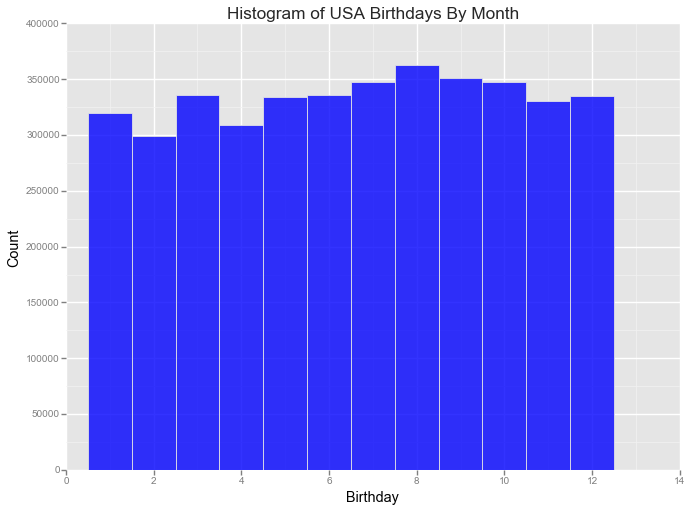

<ggplot: (274496646)>

In [11]:
plot1_cols = ['month_num', 'freq']

df_plot1 = (bday_densities[plot1_cols]
           .dropna())

plot1_breaks = (df_plot1
               .month_num
               .unique()
               .astype(int)
               .tolist())

ggplot(aes(x='month_num', y='freq'),
      data=df_plot1) +\
    geom_histogram(stat='identity',
                  fill="blue",
                  alpha=.8) +\
    xlab('Birthday') + ylab('Count') + ggtitle('Histogram of USA Birthdays By Month')

Below is a density plot for CEO birthdays by quarter using the scraped data from the wikipedia table.  It is interesting to note that this dataset shows a disproportionate number of Q1 and Q2 births compared to the population plotted above.  Further, Q3, which had the most births above, has the least births in the CEO dataset.   

/Users/alexfreedman/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


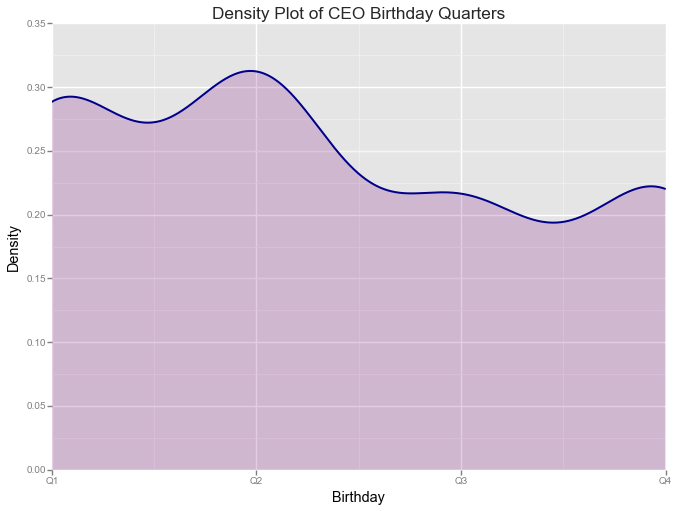

<ggplot: (294641584)>

In [14]:
plot2_cols = ['birth_quarter']

df_plot2 = (dfceo_final[plot2_cols]
            .dropna())

plot2_breaks = [1,2,3,4]

plot2_labels = ['Q1','Q2','Q3','Q4']

ggplot(aes(x='birth_quarter'),
       data=df_plot2) +\
    geom_density(colour="darkblue", 
                 size=2, 
                 fill="purple",
                 alpha=.2) +\
    scale_x_continuous(breaks = plot2_breaks,
                       labels = plot2_labels) +\
    xlab('Birthday') + ylab('Density') + ggtitle('Density Plot of CEO Birthday Quarters')

The violin plot below shows the distribution of CEO birth years across the quarters in which those CEO's were born.  Q4 CEO's appear to be slightly younger, on average.  Q2 has outliers, both young and old, because Q2 births make up the majority of the dataset. 

[[<matplotlib.text.Text at 0x11908da20>,

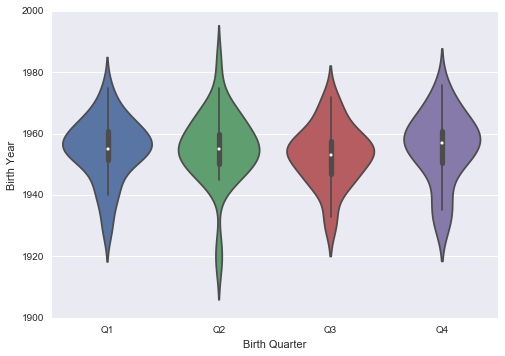

In [15]:
plot3_cols = ['birth_quarter', 'birth_year']

df_plot3 = (dfceo_final[plot3_cols]
           .dropna())

ax = sns.violinplot(x="birth_quarter", y="birth_year", data=df_plot3)
ax.set(xlabel='Birth Quarter', ylabel='Birth Year')
ax.set(xticklabels=['Q1','Q2','Q3','Q4'])

**Conclusion**

While the data set was a relatively small sample, it is interesting to see that when it is compared to the population set, Fortune 500 CEO's do appear to have a higher likelihood, albeit slightly, to be born in the first six months of a given year.  Given this data, it could be theorized that early developmental advantages and the natural leadership associated with being older than one's peers, could indicate a future of business success. 